In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms

import pandas as pd
import numpy as np
from sklearn import preprocessing

#loading data
data_white = pd.read_csv("../app/static/data/winequality-white.csv", sep =";")
data_red = pd.read_csv("../app/static/data/winequality-red.csv", sep =";")
data = pd.concat([data_red, data_white])
df = data.drop(columns=['quality'])

#data noramlization
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df.astype(float))
df = pd.DataFrame(x_scaled)

x_data = df.to_numpy()
x_data = torch.Tensor(x_data).float()

torch.set_printoptions(linewidth=120)

In [2]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(11,6)
        self.fc21 = nn.Linear(6,2)
        self.fc22 = nn.Linear(6,2)
        # decoder part
        self.fc3 = nn.Linear(2,6)
        self.fc4 = nn.Linear(6,11)
        
    def encoder(self, x):
        # encode data points, and return posterior parameters for each point.
        h = F.relu(self.fc1(x))
        mu = F.relu(self.fc21(h))
        variance = F.relu(self.fc22(h))
        return mu, variance
    
    def reparameterize(self, mu, var):
        # reparameterisation trick to sample z values
        std = torch.exp(0.5*var)
        eps = torch.randn_like(std) 
        return mu + eps*std
        
    def decoder(self, z):
        # decode latent variables
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
                   
    def forward(self, x):
        # encodes samples and then decodes them
        mu, var = self.encoder(x.view(-1, 11))
        z = self.reparameterize(mu, var)
        return self.decoder(z), mu, var
    
    def get_z(self, x):
        # encode data points x into their z representations
        mu, var = self.encoder(x.view(-1, 11))
        return self.reparameterize(mu, var)

In [3]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [4]:
def loss_function(recon_x, x, mu, var):
    # return reconstruction error + KL divergence losses
    reconstruction_loss=nn.MSELoss()
    ER = reconstruction_loss(recon_x, x)
    KL = -0.5*torch.sum(1 + var - mu.pow(2) - var.exp())  
    return ER + KL

In [5]:
def train(epoch):
    model.train()
    train_loss=0.0
    for epoch in range(1,epoch+1):
        optimizer.zero_grad()        
        recon_x, mu, var = model(x_data)
        loss = loss_function(recon_x, x_data, mu, var)        
        loss.backward()
        train_loss += loss.data
        optimizer.step()
    print(f'loss {epoch} = {loss}')

In [6]:
for epoch in range(1, 50):
    train(epoch)
    #test(epoch)

loss 1 = 101.54153442382812
loss 2 = 94.54193115234375
loss 3 = 84.76844787597656
loss 4 = 72.98837280273438
loss 5 = 60.118404388427734
loss 6 = 47.15253829956055
loss 7 = 35.02006530761719
loss 8 = 24.465190887451172
loss 9 = 15.94934368133545
loss 10 = 9.615915298461914
loss 11 = 5.335154056549072
loss 12 = 2.7693469524383545
loss 13 = 1.4275110960006714
loss 14 = 0.7843093276023865
loss 15 = 0.47463738918304443
loss 16 = 0.3160882294178009
loss 17 = 0.22679881751537323
loss 18 = 0.17167481780052185
loss 19 = 0.134816512465477
loss 20 = 0.10874737054109573
loss 21 = 0.08908122777938843
loss 22 = 0.07374291121959686
loss 23 = 0.06164395064115524
loss 24 = 0.051636986434459686
loss 25 = 0.04414800554513931
loss 26 = 0.03810093551874161
loss 27 = 0.03327509015798569
loss 28 = 0.02944016084074974
loss 29 = 0.026347197592258453
loss 30 = 0.02396286651492119
loss 31 = 0.022051196545362473
loss 32 = 0.020402446389198303
loss 33 = 0.019084777683019638
loss 34 = 0.018070951104164124
loss 35 

In [7]:
model.train()
zs = model.get_z(x_data).data.numpy()

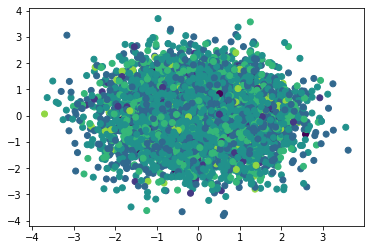

In [8]:
# white + red wine
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(zs[:,0], zs[:, 1], c=data['quality'])

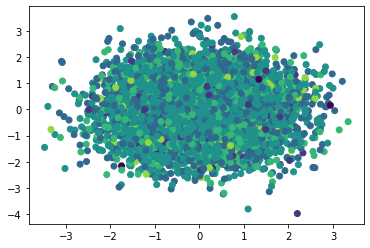

In [9]:
# white wine
model.train()
zs_white = model.get_z(x_data).data.numpy()
plt.scatter(zs_white[:,0], zs_white[:, 1], c=data['quality'])

In [10]:
x_data

tensor([[0.2975, 0.4133, 0.0000,  ..., 0.6124, 0.1910, 0.2029],
        [0.3306, 0.5333, 0.0000,  ..., 0.3721, 0.2584, 0.2609],
        [0.3306, 0.4533, 0.0241,  ..., 0.4186, 0.2416, 0.2609],
        ...,
        [0.2231, 0.1067, 0.1145,  ..., 0.2093, 0.1348, 0.2029],
        [0.1405, 0.1400, 0.1807,  ..., 0.4806, 0.0899, 0.6957],
        [0.1818, 0.0867, 0.2289,  ..., 0.4186, 0.0562, 0.5507]])

In [11]:
encoded = model.get_z(x_data)
decoded = model.decoder(encoded)
decoded

tensor([[0.2786, 0.1589, 0.1555,  ..., 0.3859, 0.1327, 0.3619],
        [0.2879, 0.1730, 0.1835,  ..., 0.3854, 0.1712, 0.3668],
        [0.2837, 0.1676, 0.1694,  ..., 0.3857, 0.1484, 0.3655],
        ...,
        [0.2772, 0.1746, 0.1867,  ..., 0.3857, 0.1476, 0.3517],
        [0.2804, 0.1824, 0.2076,  ..., 0.3826, 0.1742, 0.3559],
        [0.2841, 0.1713, 0.1982,  ..., 0.3840, 0.1955, 0.3582]], grad_fn=<SigmoidBackward>)

In [12]:
data_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2470,6.9,0.290,0.32,5.8,0.040,16.0,112.0,0.99300,3.04,0.58,11.2,5
2471,6.6,0.280,0.30,12.9,0.033,31.0,177.0,0.99479,3.12,0.39,11.2,6
2472,6.2,0.360,0.27,3.2,0.032,13.0,73.0,0.98942,2.90,0.69,12.6,7
2473,6.0,0.615,0.04,0.8,0.032,8.0,50.0,0.99036,3.14,0.40,11.0,4


In [13]:
data_white

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [14]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [15]:
labels = data['quality']
labels

0       5
1       5
2       5
3       6
4       5
       ..
4893    6
4894    5
4895    6
4896    7
4897    6
Name: quality, Length: 7373, dtype: int64

In [16]:
points = [16, 78, 168, 208, 218, 267, 401, 466, 498, 515, 530, 561, 642, 676, 710, 718, 744, 753, 803, 828, 833, 917, 965, 985, 1056, 1111, 1120, 1159, 1191, 1218, 1236, 1261, 1266, 1277, 1338, 1366, 1476, 1477, 1503, 1506, 1565, 1575, 1617, 1637, 1661, 1673, 1692, 1768, 1773, 1848, 1894, 1902, 1907, 1981, 1987, 2026, 2041, 2048, 2075, 2137, 2144, 2173, 2176, 2188, 2192, 2201, 2202, 2227, 2234, 2237, 2267, 2299, 2306, 2352, 2370, 2403, 2410, 2503, 2510, 2532, 2611, 2620, 2633, 2684, 2723, 2728, 2730, 2779, 2811, 2823, 2828, 2899, 2904, 2977, 3024, 3041, 3050, 3088, 3103, 3150, 3151, 3178, 3179, 3195, 3212, 3226, 3232, 3302, 3336, 3339, 3391, 3394, 3415, 3454, 3456, 3569, 3606, 3609, 3661, 3670, 3692, 3716, 3717, 3722, 3733, 3773, 3810, 3826, 3881, 3887, 3896, 3934, 3969, 3973, 3983, 4048, 4060, 4160, 4167, 4180, 4186, 4206, 4244, 4252, 4255, 4305, 4329, 4417, 4430, 4473, 4484, 4497, 4631, 4668, 4675, 4697, 4738, 4755, 4762, 4773, 4802, 4892, 4899, 4910, 4977, 5017, 5033, 5119, 5180, 5187, 5236, 5240, 5258, 5337, 5355, 5363, 5424, 5450, 5496, 5515, 5539, 5564, 5573, 5585, 5593, 5624, 5631, 5700, 5716, 5719, 5723, 5724, 5810, 5979, 6009, 6062, 6083, 6127, 6264, 6273, 6298, 6331, 6337, 6339, 6437, 6465, 6593, 6636, 6650, 6707, 6737, 6759, 6762, 6772, 6783, 6865, 6866, 6918, 6971, 7010, 7043, 7057, 7071, 7073, 7115, 7175, 7198, 7244, 7245, 7260, 7302, 7309, 7320, 7331, 7352, 7356]

In [17]:
selected = x_data[points]
selected

tensor([[0.3884, 0.1333, 0.3373,  ..., 0.4496, 0.2978, 0.3623],
        [0.2397, 0.4467, 0.0723,  ..., 0.5116, 0.1685, 0.3043],
        [0.2479, 0.3667, 0.0422,  ..., 0.5814, 0.1854, 0.3478],
        ...,
        [0.2727, 0.1000, 0.2349,  ..., 0.1395, 0.1348, 0.1449],
        [0.1736, 0.3067, 0.0000,  ..., 0.4109, 0.0787, 0.1159],
        [0.0992, 0.1033, 0.1627,  ..., 0.2713, 0.1573, 0.2029]])

In [18]:
selected.shape

torch.Size([236, 11])

In [19]:
x_data.shape

torch.Size([7373, 11])

In [20]:
zs_selected = model.get_z(selected).data.numpy()

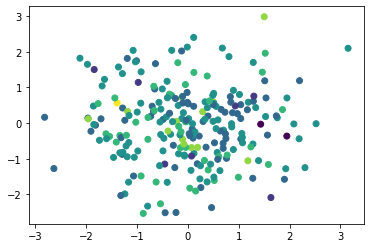

In [21]:
plt.scatter(zs_selected[:,0], zs_selected[:, 1], c=data['quality'].iloc[points])

In [22]:
df_yes = pd.DataFrame({'x':zs_selected[:,0], 'y':zs_selected[:, 1], 'label':data['quality'].iloc[points], 'trained':'yes'})

In [23]:
arr_no = np.delete(zs, [points], axis=0)

In [24]:
labels = data['quality'].to_numpy()

In [25]:
arr_no_labels = np.delete(labels, [points])

In [26]:
df_no = pd.DataFrame({'x':arr_no[:,0], 'y':arr_no[:, 1], 'label':arr_no_labels, 'trained':'no'})

In [27]:
labels.shape

(7373,)

In [28]:
x = 7373 - 7137
x

236